# Определение возраста покупателей

Наша задача - подготовка анализатора для системы компьютерного зрения Сетевого супермаркета «Хлеб-Соль». Заказчик внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.


## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import warnings

Скрытие предупреждений

In [2]:
pd.options.mode.chained_assignment = None

warnings.filterwarnings('ignore')

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

import matplotlib.pyplot as plt import seaborn as sns import warnings from IPython.display import display from scipy import stats as st

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
full_datagen = ImageDataGenerator(rescale=1./255)
full_gen_flow = full_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Мы решаем задачу регрессии, которая представляет собой присвоение возраста (от 1 до 99) на основании визуальных признаков одному из 7591 объекта. Если признаки представлены равномерно, то на каждый возраст приходится меньше восьмидесяти фотографий. (сколько на самом деле - мы увидим чуть ниже). И этого маловато для достоверного выявления признаков. На мой взгляд, мы должны выполнить особую аугментацию, не с изменением изображений в текущем датасете, а с созданием дополнительных блоков аугментированных изображений - с осветлением, поворотами, смещением центра.


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Посмотрим на размер выборки.

In [7]:
features, target = next(full_gen_flow)

features, target = next(train_gen_flow)
features, target = next(train_gen_flow)
Построим график распределения возраста в батче.

In [8]:
features.shape

(32, 224, 224, 3)

In [9]:
len(features)

32

In [10]:
len(target)

32

In [11]:
features

array([[[[0.5764706 , 0.5137255 , 0.454902  ],
         [0.53333336, 0.47058827, 0.41176474],
         [0.5294118 , 0.4666667 , 0.40784317],
         ...,
         [0.48235297, 0.4156863 , 0.30588236],
         [0.49411768, 0.427451  , 0.31764707],
         [0.49803925, 0.43137258, 0.32156864]],

        [[0.5176471 , 0.454902  , 0.39607847],
         [0.5058824 , 0.4431373 , 0.38431376],
         [0.5529412 , 0.4901961 , 0.43137258],
         ...,
         [0.49803925, 0.43137258, 0.32156864],
         [0.50980395, 0.4431373 , 0.33333334],
         [0.50980395, 0.4431373 , 0.33333334]],

        [[0.5176471 , 0.45098042, 0.38823533],
         [0.5058824 , 0.43921572, 0.37647063],
         [0.5176471 , 0.45098042, 0.38823533],
         ...,
         [0.5019608 , 0.43529415, 0.3254902 ],
         [0.50980395, 0.4431373 , 0.33333334],
         [0.5058824 , 0.43921572, 0.32941177]],

        ...,

        [[0.06666667, 0.45882356, 0.52156866],
         [0.08235294, 0.47450984, 0.5372549 ]

Построим график распределения возраста в выборке.

Напечатаем несколько фотографий и посмотрим, как устроен датасет.

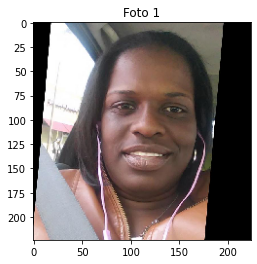

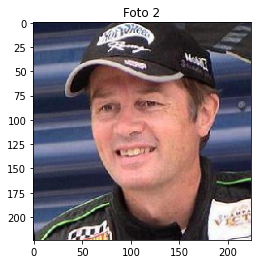

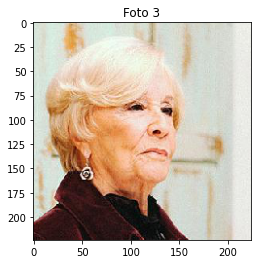

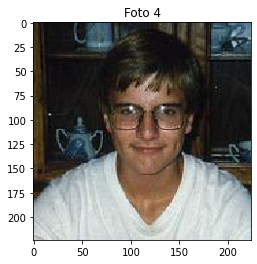

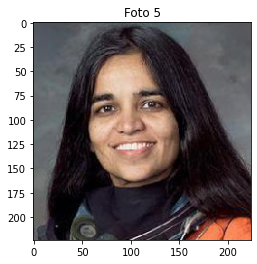

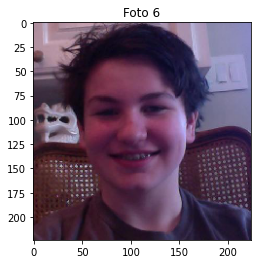

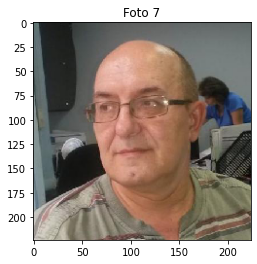

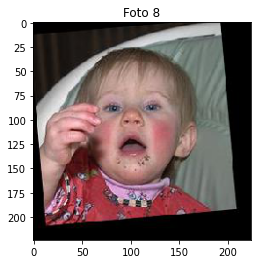

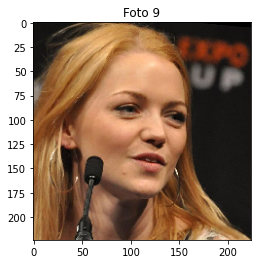

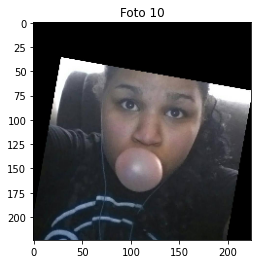

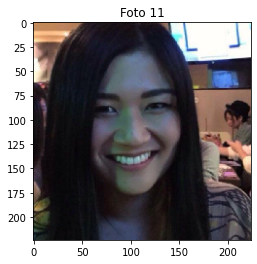

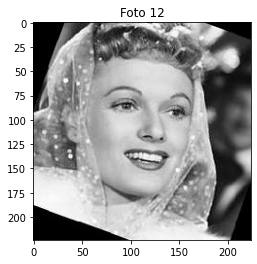

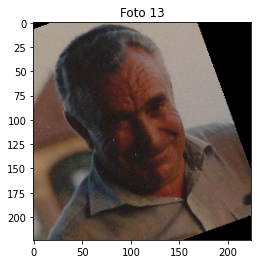

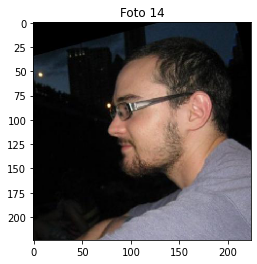

In [12]:
for i in range(1,15):
    plt.imshow(features[i])
    tit = 'Foto '+ str(i)
    plt.title(tit)
    plt.show()
    print('')

Сделаю свои предсказания, в целом я довольно хорошо определяю возраст. Создаем вектор.

In [13]:
my_predict = np.array([47, 35, 50, 80, 16, 37, 13, 60,  2, 28])
my_predict

array([47, 35, 50, 80, 16, 37, 13, 60,  2, 28])

А теперь достанем записанное в лэйблах.

In [14]:
target[:10]

array([50, 41, 46, 85, 14, 40, 14, 53,  4, 32])

Что?!! ребенку целых 4 года??? Удивительно, по виду - больше полутора, но меньше 2,5. Нда, может быть, меня смущает его неопрятность в еде... то есть я добавляю эпивнешностные факторы. Посмотрим, насколько я ошиблась с этой десяткой. Ни одного совпадения, минимальная разница - год.

In [15]:
print("MAE:", mean_absolute_error(target[:10], my_predict)) 

MAE: 3.7


In [16]:
print("RMSE:", mean_absolute_error(target[:10], my_predict)**0.5) 

RMSE: 1.9235384061671346


Средняя абсолютная ошибка всего на 10 персонах - 3.7, RMSE - 1.92.

In [17]:
target.min()

4

In [18]:
target.max()

94

In [19]:
target.mean()

35.46875

In [20]:
np.median(target)

31.0

Построим график распределения возраста в выборке.

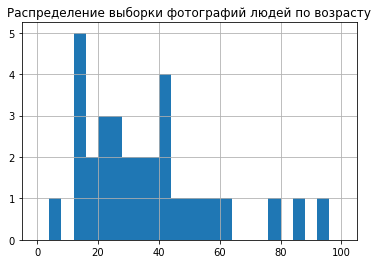

In [21]:
pd.Series(target).hist(range = (0,100), bins = 25)
plt.title('Распределение выборки фотографий людей по возрасту в батче')
plt.show()


Наши 32 образца распределены по возрасту более-менее нормально. Представленные люди разного пола. Образцов, конечно, маловато. По многим возрастам - по 1 лицу

Мы видим, что у нас довольно небольшой набор фотографий - 32 фото и 32 лэйбла к ним, наша цель - обучить свёрточную нейронную сеть на датасете с фотографиями людей. Нашей функцией потерь будет 'mean_squared_error', метрикой качества - 'mean_absolute_error'. Задача минимум - добиться значения MAE на тестовой выборке не больше 8, задача "на отлично" - MAE меньше 7

Для обсчёта такой сложной задачи выбираем наилучшую из известных нам сверточных сетей - ResNet. 

<div class="alert alert-info"> <b>Комментарий студента 1:</b> Ниже - график аспределение фотографий людей по реальному возрасту </div>

In [22]:
labels.columns

Index(['file_name', 'real_age'], dtype='object')

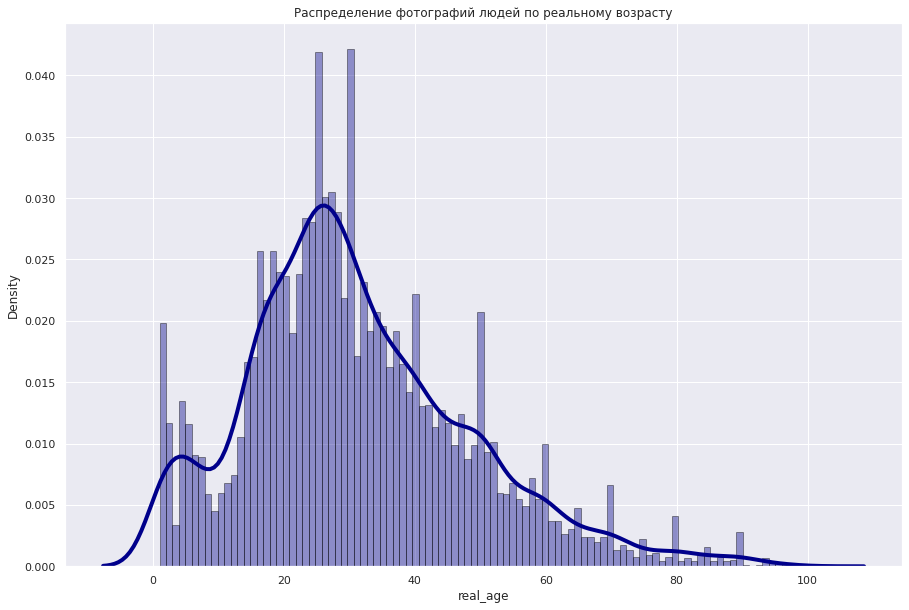

In [23]:
sns.set(rc={'figure.figsize':(15,10)})
sns.distplot(labels['real_age'], hist=True, kde=True, 
             bins=100, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},
             )
plt.title('Распределение фотографий людей по реальному возрасту')
plt.show()


 Мы видим почти нормальное распределение частот возрастов с регулярными выбросами в круглые даты. В первое десятилетие наибольшее число фотографий у первого года жизни. В дальнейшем число лиц растёт и есть выбросы в 25, 30, 40, 50, 60, 70, 80 и 90 лет. В юбилеи люди фотографируются чаще. Это создаёт неравномерность распределения - точки тяготения к возрастам с бОльшими весами. Минимальный возраст - один год. Средний возраст - 31.2, медианны - 29 лет. Совокупность сдвинута влево, в сторону более молодых лиц. На возраст 42 и более лет приходится всего 25% совокупности. Макисмальный возраст - 100. На фотографиях представлены лица обоих полов, разных рас. На фотографиях помимо лиц встречаются посторонние предметы в кадре, конкурирующие по яркости с изображением лица или частично закрывающие лицо, что ухудшает распознавание. Часть фотографий подвергнута повороту на 5 градусов (наклон я проверяла), что рекомендуется для обработки. . Встречаются фотографии в профиль, что кардинально отличается при распознавании (в сторону ухудшения ). На фото лица взяты крупным планом, лицо находится близко к центру фотографии или несколько смещено от центра. 

 Размер датасета 7591 фотография. Однозначную оценку, достаточно ли этого количества фотографий для решения поставленной задачи я дать не могу. Quod est достаточно? У нас есть гендерные и расовые различия проявления возраста. Моё предположение, что этого количества недостаточно для точного распределения признака. Но у нас есть критерии задачи, и создать модель, которая будет удовлетворять критериям нам по силам. Значит, достаточно. Одной из целей является контроль добросовестности кассиров при продаже алкоголя. Эта задача точно может быть решена. Закладываем проверку всех, кто попадает под критерий меньше (18 лет + наша средняя ошибка по модулю) - и существенно улучшаем показатель. Так как у нас не медицинское исследование, то критерий точности здесь не настолько существенен. Для рекомендаций его точно будет достаточно.
Рекомендованные  и не рекомендованные аугментации:
* Поворот уже сделан - rotation не рекомендуется.
* Изображения уже смещены по отношению к центру - shift не рекомендуется
* не рекомендуется вертикальный поворот - камера будет висеть в определенном месте и вероятность того, что люди будут расплачиваться стоя на руках блика к нулю
* рекомендуется горизонтальный поворот - параметр horizontal_flip
* рекомендуется увеличение масштаба для большей площади лица - параметр zoom_range
* рекомендуется отбеливание zca - параметр zca_whitening (подчеркивание границ -  наши черты лица и морщины)
Ниже я добавлю результаты по модели с этими параметрами.
    

## Обучение модели

Наша сверточная сеть - ResNet. Делаем костяк, не замораживая топ. Могли заморозить, но в предыдущем задании нам сказали - не надо.
```python
   backbone = ResNet50(input_shape=input_shape,
             include_top=False,
#Веса берем из соответствующей директории:   
    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    ```

```python
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd
 
def load_train(path):
    labels = pd.read_csv(path +'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                  rescale=1./255,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                      )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
         
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path +'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                  rescale=1/255
                                 )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
         
    return test_gen_flow
 
 
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=16,
               steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model


```

Первый раз было без аугментации. Результат ниже:

```
Epoch 7/10
178/178 - 39s - loss: 9.6952 - mean_absolute_error: 2.3925 - val_loss: 69.5533 - val_mean_absolute_error: 6.3038
Epoch 8/10
178/178 - 39s - loss: 8.7850 - mean_absolute_error: 2.2193 - val_loss: 65.7750 - val_mean_absolute_error: 6.1081
Epoch 9/10
178/178 - 40s - loss: 7.9928 - mean_absolute_error: 2.0904 - val_loss: 74.4494 - val_mean_absolute_error: 6.6999
Epoch 10/10
178/178 - 39s - loss: 7.3690 - mean_absolute_error: 2.0384 - val_loss: 81.6129 - val_mean_absolute_error: 6.7924

```

Вывод, что модель переобучается после 8 эпохи mean_absolute_error на тренировочной выборке идет вниз, а val_mean_absolute_error на валидационной начинает повышаться. Чтобы улучшить показатели попробуем добавить аугментацию. Добавим в train_datagen параметры horizontal_flip=True, vertical_flip=True. 

```
Epoch 1/8
2023-01-24 18:28:07.021879: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-24 18:28:07.371597: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 59s - loss: 382.7492 - mean_absolute_error: 14.2136 - val_loss: 720.6884 - val_mean_absolute_error: 21.9007
Epoch 2/8
178/178 - 42s - loss: 111.3074 - mean_absolute_error: 7.9907 - val_loss: 443.1984 - val_mean_absolute_error: 15.9503
Epoch 3/8
178/178 - 40s - loss: 86.0888 - mean_absolute_error: 7.0306 - val_loss: 320.9306 - val_mean_absolute_error: 13.2908
Epoch 4/8
178/178 - 42s - loss: 67.9014 - mean_absolute_error: 6.2429 - val_loss: 177.2467 - val_mean_absolute_error: 10.6159
Epoch 5/8
178/178 - 51s - loss: 58.4292 - mean_absolute_error: 5.7945 - val_loss: 122.1701 - val_mean_absolute_error: 8.2363
Epoch 6/8
178/178 - 51s - loss: 46.7318 - mean_absolute_error: 5.2008 - val_loss: 89.5231 - val_mean_absolute_error: 7.2832
Epoch 7/8
178/178 - 40s - loss: 40.0551 - mean_absolute_error: 4.8383 - val_loss: 78.2495 - val_mean_absolute_error: 6.5560
Epoch 8/8
178/178 - 48s - loss: 34.6248 - mean_absolute_error: 4.4839 - val_loss: 73.9994 - val_mean_absolute_error: 6.3739
WARNING:tensorflow:sample_weight modes were coerced from
```

Так, я тут остановилась на 8 эпохах, а явно можно улучшить результат, переобучение снизилось (или разбилось по-другому). Но всё же увеличим количество эпох и посмотрим, что осталось за горизонтом.

```
Train for 178 steps, validate for 60 steps
Epoch 1/16
2023-01-24 19:23:37.364208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-24 19:23:39.577213: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 65s - loss: 278.4984 - mean_absolute_error: 12.0983 - val_loss: 877.2370 - val_mean_absolute_error: 24.7569
Epoch 2/16
178/178 - 38s - loss: 101.7401 - mean_absolute_error: 7.6471 - val_loss: 610.2818 - val_mean_absolute_error: 19.5833
Epoch 3/16
178/178 - 38s - loss: 78.0666 - mean_absolute_error: 6.6598 - val_loss: 240.4260 - val_mean_absolute_error: 12.2300
Epoch 4/16
178/178 - 38s - loss: 64.6044 - mean_absolute_error: 6.0838 - val_loss: 137.7638 - val_mean_absolute_error: 8.8205
Epoch 5/16
178/178 - 38s - loss: 52.4149 - mean_absolute_error: 5.5063 - val_loss: 135.2956 - val_mean_absolute_error: 8.7990
Epoch 6/16
178/178 - 38s - loss: 44.8292 - mean_absolute_error: 5.0761 - val_loss: 86.7682 - val_mean_absolute_error: 6.9593
Epoch 7/16
178/178 - 38s - loss: 40.8321 - mean_absolute_error: 4.8107 - val_loss: 114.6280 - val_mean_absolute_error: 8.4182
Epoch 8/16
178/178 - 38s - loss: 33.5592 - mean_absolute_error: 4.4343 - val_loss: 85.3123 - val_mean_absolute_error: 6.9047
Epoch 9/16
178/178 - 38s - loss: 29.4304 - mean_absolute_error: 4.1374 - val_loss: 86.0270 - val_mean_absolute_error: 6.7353
Epoch 10/16
178/178 - 38s - loss: 25.8661 - mean_absolute_error: 3.8630 - val_loss: 74.7154 - val_mean_absolute_error: 6.5799
Epoch 11/16
178/178 - 38s - loss: 23.1174 - mean_absolute_error: 3.6588 - val_loss: 81.3145 - val_mean_absolute_error: 6.8404
Epoch 12/16
178/178 - 38s - loss: 20.8787 - mean_absolute_error: 3.4949 - val_loss: 72.9063 - val_mean_absolute_error: 6.5604
Epoch 13/16
178/178 - 38s - loss: 19.5517 - mean_absolute_error: 3.4129 - val_loss: 68.8946 - val_mean_absolute_error: 6.2262
Epoch 14/16
178/178 - 38s - loss: 16.5745 - mean_absolute_error: 3.1138 - val_loss: 84.3871 - val_mean_absolute_error: 6.7356
Epoch 15/16
178/178 - 38s - loss: 15.7972 - mean_absolute_error: 3.0216 - val_loss: 77.8658 - val_mean_absolute_error: 6.6246
Epoch 16/16
178/178 - 38s - loss: 14.1768 - mean_absolute_error: 2.8890 - val_loss: 71.5238 - val_mean_absolute_error: 6.1727
```

Так как здесь переобучения не наблюдалось, я увеличила количество эпох до 20, но с 17 эпохи снова пошло ухудшение. 

```
Train for 178 steps, validate for 60 steps
Epoch 1/20
2023-01-25 12:07:21.467949: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-25 12:07:22.007513: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 62s - loss: 299.3608 - mean_absolute_error: 12.4834 - val_loss: 443.4620 - val_mean_absolute_error: 15.9783
Epoch 2/20
178/178 - 47s - loss: 105.8126 - mean_absolute_error: 7.8473 - val_loss: 436.6037 - val_mean_absolute_error: 15.8103
Epoch 3/20
178/178 - 48s - loss: 84.8471 - mean_absolute_error: 6.9259 - val_loss: 283.6978 - val_mean_absolute_error: 12.4556
Epoch 4/20
178/178 - 48s - loss: 65.5857 - mean_absolute_error: 6.1610 - val_loss: 123.6463 - val_mean_absolute_error: 8.5008
Epoch 5/20
178/178 - 49s - loss: 55.3357 - mean_absolute_error: 5.6471 - val_loss: 99.1788 - val_mean_absolute_error: 7.6099
Epoch 6/20
178/178 - 38s - loss: 44.5724 - mean_absolute_error: 5.0825 - val_loss: 106.2133 - val_mean_absolute_error: 7.5749
Epoch 7/20
178/178 - 37s - loss: 39.6802 - mean_absolute_error: 4.7999 - val_loss: 83.4658 - val_mean_absolute_error: 6.9027
Epoch 8/20
178/178 - 37s - loss: 34.1922 - mean_absolute_error: 4.4739 - val_loss: 77.9115 - val_mean_absolute_error: 6.5869
Epoch 9/20
178/178 - 37s - loss: 28.6316 - mean_absolute_error: 4.1084 - val_loss: 76.0849 - val_mean_absolute_error: 6.6566
Epoch 10/20
178/178 - 37s - loss: 27.4658 - mean_absolute_error: 4.0030 - val_loss: 74.9924 - val_mean_absolute_error: 6.5183
Epoch 11/20
178/178 - 38s - loss: 25.2041 - mean_absolute_error: 3.8086 - val_loss: 71.8362 - val_mean_absolute_error: 6.2425
Epoch 12/20
178/178 - 40s - loss: 21.2377 - mean_absolute_error: 3.4957 - val_loss: 73.3551 - val_mean_absolute_error: 6.5010
Epoch 13/20
178/178 - 40s - loss: 18.6362 - mean_absolute_error: 3.2647 - val_loss: 83.9486 - val_mean_absolute_error: 6.8703
Epoch 14/20
178/178 - 42s - loss: 15.9771 - mean_absolute_error: 3.0798 - val_loss: 72.7037 - val_mean_absolute_error: 6.4235
Epoch 15/20
178/178 - 41s - loss: 15.0755 - mean_absolute_error: 2.9342 - val_loss: 71.9495 - val_mean_absolute_error: 6.5605
Epoch 16/20
178/178 - 41s - loss: 13.9854 - mean_absolute_error: 2.8583 - val_loss: 68.1290 - val_mean_absolute_error: 6.1883
Epoch 17/20
178/178 - 40s - loss: 12.4285 - mean_absolute_error: 2.6886 - val_loss: 67.8608 - val_mean_absolute_error: 6.1996
Epoch 18/20
178/178 - 46s - loss: 12.1087 - mean_absolute_error: 2.6602 - val_loss: 70.9745 - val_mean_absolute_error: 6.2922
Epoch 19/20
178/178 - 49s - loss: 11.0322 - mean_absolute_error: 2.5166 - val_loss: 71.9060 - val_mean_absolute_error: 6.4035
Epoch 20/20
178/178 - 65s - loss: 11.5867 - mean_absolute_error: 2.6014 - val_loss: 74.1621 - val_mean_absolute_error: 6.3676
```

Ну что же, лучший результат получился 6.17. Вполне приемлемо, модель уложилась с обучением в отведённые полчаса. Хорошо бы, конечно, выудить сами предсказания, посмотреть accuracy, например. И да, мой личный rmse 1.9 уже не кажется таким ужасным.

## Анализ обученной модели

Модель ResNet50, обучается в отведенные по заданию полчаса. Веса использовались специально рассчитанные ранее. Модель собрана из трёх последовательных слоев backbone (сама ResNet50) + сверточный слой GlobalAveragePooling2D + Полносвязный слой Dense с одним нейроном и активацией 'relu', так как у нас задача регрессии. Первый слой принимает массив 224 х 224 х3. Но на выходе уже 7 х 7 х 2048.  Для сборки мы использовали оптимизатор Адам с шагом 0.0001, планировалось уменьшить шаг, если модель не уложится в отведенные полчаса, но всё получилось. Функция потерь - 'mean_squared_error', метрика качества - 'mean_absolute_error'. 

Вывод summary модели:

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
```

Я попыталась вывести сами значения предсказаний, и это частично получилось, но без индексов не имеет смысла:

```
[[14.750017]
 [16.801283]
 [30.157671]
 ...
 [23.040548]
 [48.880875]
 [ 0.      ]]
 ```

Интересно, что какой-то фотографии досталась оценка 0., при том, что минимум был 4 года.

Модель показала результат лучший результат 6.17, который в соответствии с градацией задания, отличный, так как < 7. Модель уложилась с обучением в отведённые полчаса. Но на её фоне мой личный rmse 1.9 уже не кажется таким ужасным.

```Epoch 1/20
2023-01-26 10:30:08.156774: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-26 10:30:08.696855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 102s - loss: 243.0377 - mean_absolute_error: 11.2404 - val_loss: 920.3897 - val_mean_absolute_error: 25.5205
Epoch 2/20
178/178 - 92s - loss: 83.8088 - mean_absolute_error: 6.9403 - val_loss: 661.9143 - val_mean_absolute_error: 20.4636
Epoch 3/20
178/178 - 88s - loss: 59.1463 - mean_absolute_error: 5.8643 - val_loss: 250.4629 - val_mean_absolute_error: 12.3415
Epoch 4/20
178/178 - 92s - loss: 42.2362 - mean_absolute_error: 4.9560 - val_loss: 107.2772 - val_mean_absolute_error: 7.7256
Epoch 5/20
178/178 - 95s - loss: 35.6924 - mean_absolute_error: 4.5960 - val_loss: 110.8896 - val_mean_absolute_error: 7.9618
Epoch 6/20
178/178 - 93s - loss: 29.9860 - mean_absolute_error: 4.2005 - val_loss: 70.1042 - val_mean_absolute_error: 6.1360
Epoch 7/20
178/178 - 93s - loss: 26.4667 - mean_absolute_error: 3.9341 - val_loss: 74.4269 - val_mean_absolute_error: 6.3638
Epoch 8/20
178/178 - 100s - loss: 21.6776 - mean_absolute_error: 3.5914 - val_loss: 83.3571 - val_mean_absolute_error: 7.0891
Epoch 9/20
178/178 - 93s - loss: 19.0568 - mean_absolute_error: 3.3634 - val_loss: 69.1882 - val_mean_absolute_error: 6.2061
Epoch 10/20
178/178 - 90s - loss: 17.2731 - mean_absolute_error: 3.2121 - val_loss: 62.1039 - val_mean_absolute_error: 5.9441
Epoch 11/20
178/178 - 92s - loss: 13.9494 - mean_absolute_error: 2.9039 - val_loss: 66.2980 - val_mean_absolute_error: 5.9522
Epoch 12/20
178/178 - 92s - loss: 13.7746 - mean_absolute_error: 2.8459 - val_loss: 66.7277 - val_mean_absolute_error: 6.1379
Epoch 13/20
178/178 - 91s - loss: 12.2001 - mean_absolute_error: 2.6726 - val_loss: 64.8756 - val_mean_absolute_error: 5.9086
Epoch 14/20
178/178 - 86s - loss: 10.9899 - mean_absolute_error: 2.5628 - val_loss: 74.9436 - val_mean_absolute_error: 6.3760
Epoch 15/20
178/178 - 96s - loss: 10.6994 - mean_absolute_error: 2.4932 - val_loss: 70.3546 - val_mean_absolute_error: 6.2561
Epoch 16/20
178/178 - 95s - loss: 9.9976 - mean_absolute_error: 2.4034 - val_loss: 65.7375 - val_mean_absolute_error: 5.9761
Epoch 17/20```


 <b> В ячейке выше - наша новая модель </b> Масштаб или отбеливание zca дали такой эффект - я не знаю, интересно было бы прогнать их по отдельности. Но модель уже дважды застревает на 17 эпохах, и я приняла решение отправить на текущем уровне проработки. Может быть, на 20 будет еще лучше - сейчас стоит в очереди в очередной раз. Предыдущая лучшая версия была с показателями: mean_absolute_error: 2.6014 - val_loss: 74.1621 - val_mean_absolute_error: 6.3676 на 20 эпохе. Наша новая версия - mean_absolute_error: 2.4034 - val_loss: 65.7375 - val_mean_absolute_error: 5.9761
Epoch 17/20. Достигнута первая цифра 5!!! 

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы